### Data and dependencies

In [ ]:
#importing libraries
import tensorflow as tf
import numpy as np
import keras 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#loading dataset arrays
#fonction pour importer les données préalablement sauvées dans Drive
loaded = np.load('/content/drive/MyDrive/TM/jupyter/datasets/TM_dataset_10k.npz') 

array1 = loaded['array1_drm']
array2 = loaded['array2_pia']
array3 = loaded['array3_gtr']
array4 = loaded['array4_bss']

In [ ]:
# sépare la matrice de la batterie en ses 3 composantes
array1_1=array1[:,:,:9]     # notes         [0,1]       (multi-hot encoding)
array1_2=array1[:,:,9:18]   # velocities    [0,1]       (regression)
array1_3=array1[:,:,18:27]  # time offsets  [-0.5,0.5[  (regression)

In [ ]:
def decoder_input_arrays(array_): 
    """fonction pour préparer les inputs du décodeur. Étant donné que j'utilise la méthode
        de Teacher-forcing, je 'feed' au décodeur à chaque le pas précédent correct, à la
        place du pas précédent généré (souvent faux au début de l'entraînement)"""
    array=np.copy(array_)
    for batch in range(array.shape[0]):
        padded = np.pad(array[batch],((1,0),(0,0)))
        for t in range(array.shape[1]):
            for i in range(array.shape[2]):
                array[batch,t,i]=padded[t,i]
    return array

In [ ]:
array1_4=decoder_input_arrays(array1_1)
array1_5=decoder_input_arrays(array1_2)
array1_6=decoder_input_arrays(array1_3)

# Model


> ## Defining the model

In [ ]:
###Hyperparamètres du modèle

#units
units1_1,units1_2,units1_3 = 200,200,200
units2 = 500 
latent_units = 256
units3_1, units3_2 = 256,256
#training hyperparameters
epochs=100
batch_size=64 #taille des échantillons

mse = keras.losses.MeanSquaredError() # erreur quadratique moyenne, utilisée ensuite pour les vélocités et le micro-timg
precision_at_recall = keras.metrics.PrecisionAtRecall(0.7)
# indicateur de perfomance mesurant la précison (PPV) du modèle pour un rappel donné (70%)
#-> mesure la proportion de faux positifs sur les premiers 70% des notes positives (en partant du haut (1))

val_ratio = 0.25 # percent of samples used for validation and not seen before by the model
dataset_ratio = 1  # while testing, it can be useful to use a smaller dataset for runtime's sake

In [ ]:
# fonction d'erreur personnalisée pour les notes
# J'ai fait plusieurs variantes (dont je visualisais le courbes avec geogebra).
# J'ai testé divers fonctions, 
    # certaines plus ou moins aggressives sur des prédictions lointaines,
    # ou avec différents coefficients entre l'erreur des notes positives et des notes négatives 
def weighted_crossentropy_2(y_true,y_pred): 
    return y_true * -keras.backend.log(y_pred) * 3 * (1-y_pred)*2 + (1 - y_true) * -keras.backend.log(1 - y_pred) * y_pred*2

In [ ]:
# Préparation des datasets entrée et cible, pour l'entraînement et l'évaluation

# reshaping datasets to multiples of batch size:
length=array2.shape[0]
print(length)

length *= dataset_ratio

#-- train data
x=length*(1-val_ratio)
n=int(x-(x%batch_size))

inputs= [array2[:n],array3[:n],array4[:n],array1_4[:n],array1_5[:n],array1_6[:n]]
targets=[array1_1[:n],array1_2[:n],array1_3[:n]]

#--- validation data
x=length*val_ratio
m=int(x-(x%batch_size))

val_inputs= [array2[n:n+m],array3[n:n+m],array4[n:n+m],array1_4[n:n+m],array1_5[n:n+m],array1_6[n:n+m]]
val_targets=[array1_1[n:n+m],array1_2[n:n+m],array1_3[n:n+m]]

print(inputs[0].shape)
print(f'{int(n/batch_size)} batches')
print(val_inputs[0].shape)
print(f'{int(m/batch_size)} batches')

10000
(7488, 128, 128)
117 batches
(2496, 128, 128)
39 batches


In [ ]:
# Couches personnalisées
# elles me permettent d'avoir une architecture originale
# et de pouvoir diverger des fonctions 'high-level' mises à disposition par Keras

class Sampling(keras.layers.Layer):
    """couche qui s'occupe d'échantillonner z avec les paramètres de distributions (z_mean, z_log_var) """
    def call(self,inputs):
        z_mean,z_log_var=inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5*z_log_var) * epsilon

class KL_Divergence(keras.layers.Layer):
    """cette couche calcule l'erreur de la partie VIB du modèle
        elle utilise la 'Kullback-Leibler Divergence' pour évaluer l'espace latent,
        et rajoute l'erreur au modèle à travers la fonction add_loss() intégrée de keras"""
    def call(self,inputs):
        z_mean,z_log_var=inputs
        return -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1) # KL div. loss

class ConductorRNN(keras.layers.Layer):
    """couche supérieure du décodeur hiérarchique, inspiré du décodeur inédit de MusicVAE"""
    def __init__(self,units=256,name='conductorRNN',has_splits=True,num_splits=4,**kwargs):
        super(ConductorRNN,self).__init__(name=name,**kwargs)
        self.num_splits=num_splits
        self.lstm_cell = layers.LSTMCell(units)
        self.split_length=int(128/num_splits)
    def call(self,x):
        predictions=[]
        state=self.lstm_cell.get_initial_state(x)
        for i in range(self.num_splits):
            x,state = self.lstm_cell(x,states=state)
            predictions.append(x)
        return predictions
        #return tf.stack(predictions) # for when we want a 3D output Tensor instead of a python list
class RNN_Helper(keras.layers.Layer):
    # i created this to clean off the input preparation following the conductorRNN output
    # it was messing up the graphs and making them unreadable due to too many instances of RepeatVector and Concatenate
    def __init__(self,split_length=32,name='helper'):
        super(RNN_Helper,self).__init__(name=name)
        self.repeat = layers.RepeatVector(split_length)
        self.concat = layers.Concatenate(axis=2)
    def call(self,inputs):
        dec_input,c=inputs
        return self.concat([dec_input,self.repeat(c)])


class State_Embedder(keras.layers.Layer):
    """couche qui initialise "l'état" du décodeur inférieur à chaque sous-séquence avec le vecteur conducteur correspondant"""
    def __init__(self,units=256,name='state_Embedder',**kwargs):
        super(State_Embedder,self).__init__(name=name,**kwargs)
        self.dense=layers.Dense(units*2,activation='tanh')
    def call(self,c):
        c=self.dense(c)
        return tf.split(c,2,axis=1)

class Input_Splitter(keras.layers.Layer):
    """couche qui ne sert qu'à faciliter le traitement de données (tout comme HelperRNN)"""
    def __init__(self,num_splits=4):
        super(Input_Splitter,self).__init__()
        self.num_splits=num_splits
    def call(self,input):
        return tf.split(input,num_splits,axis=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(64, 128, 128)]     0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(64, 128, 128)]     0                                            
__________________________________________________________________________________________________
input3 (InputLayer)             [(64, 128, 128)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (64, 32, 32)         16416       input1[0][0]                     
______________________________________________________________________________________________

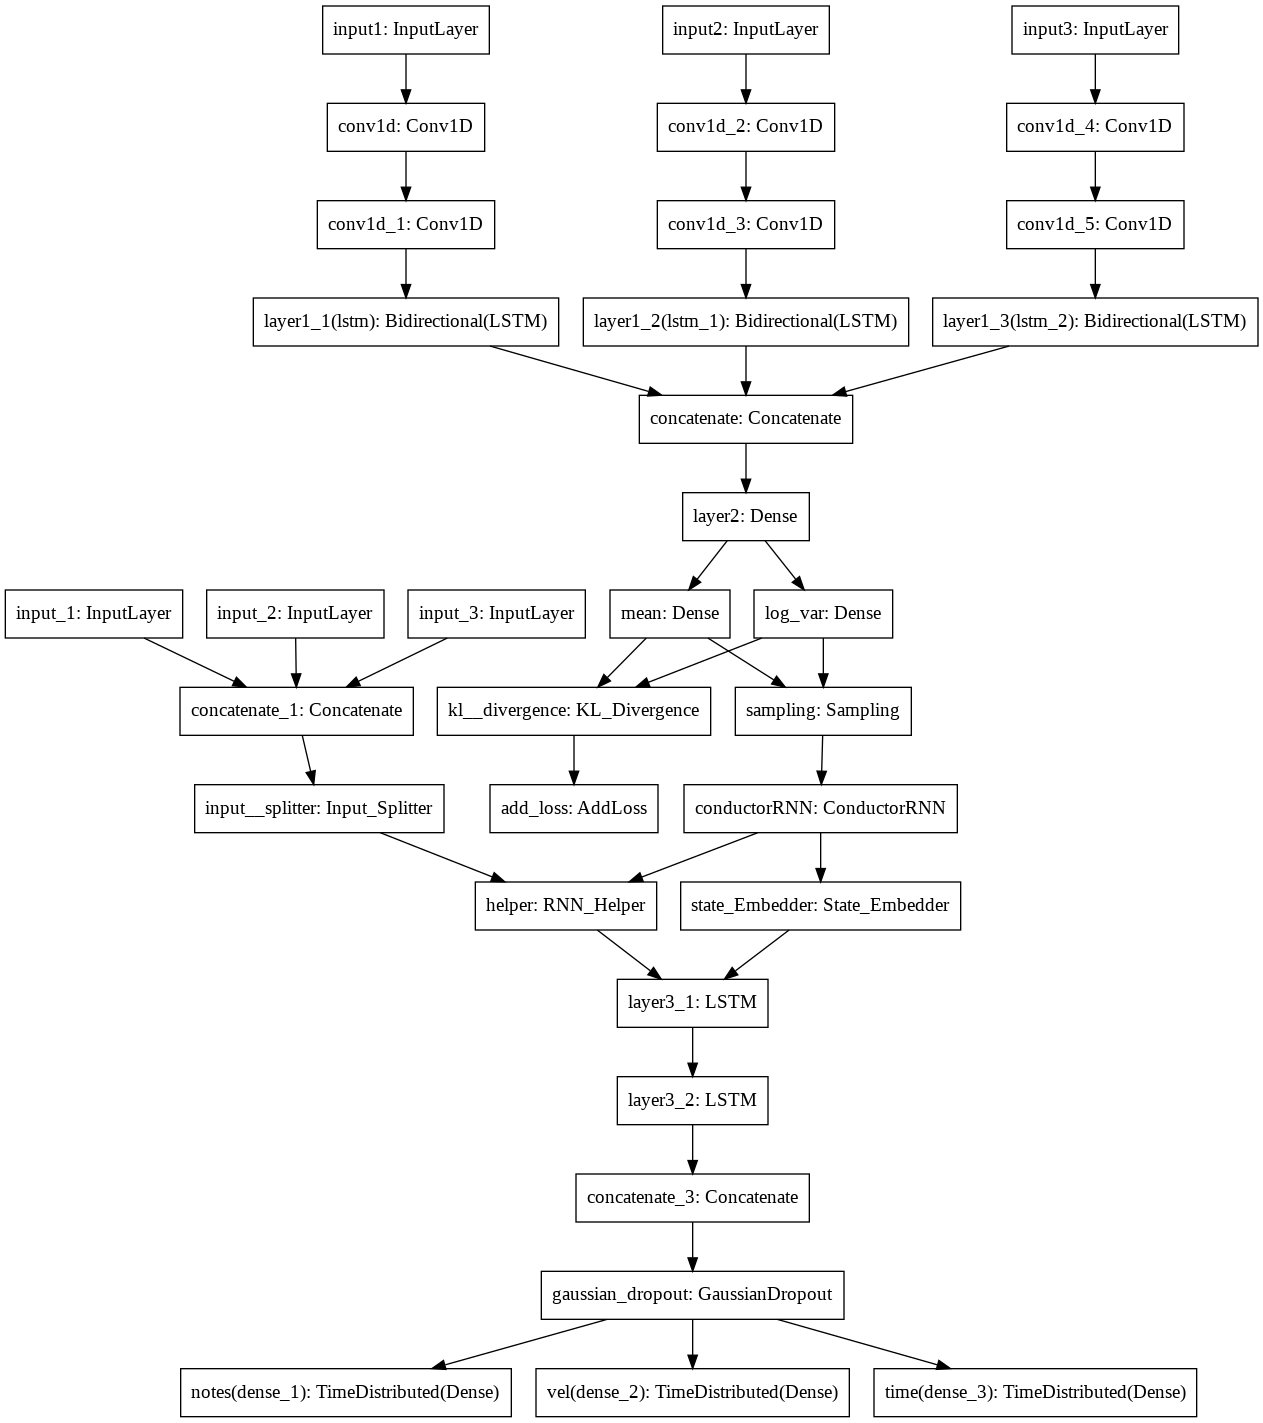

In [ ]:
#model
from keras import layers
from keras.layers import LSTM
from keras.layers import TimeDistributed as TD
from keras.layers import Bidirectional as BD
from keras.layers import Input

    ###ENCODER
# inputs
input_layer1 = Input(shape=(128,128),batch_size=batch_size,name='input1')
input_layer2 = Input(shape=(128,128),batch_size=batch_size,name='input2')
input_layer3 = Input(shape=(128,128),batch_size=batch_size,name='input3')

model_encoder_inputs=[input_layer1,input_layer2,input_layer3]

# Bidirectional CNN-LSTM for each instrument 
conv_layer1_1= layers.Conv1D(filters=32,kernel_size=4,strides=4)(input_layer1) 
conv_layer1_2= layers.Conv1D(filters=64,kernel_size=4,strides=2)(conv_layer1_1) 

conv_layer2_1= layers.Conv1D(filters=32,kernel_size=4,strides=4)(input_layer2) 
conv_layer2_2= layers.Conv1D(filters=64,kernel_size=4,strides=2)(conv_layer2_1) 

conv_layer3_1= layers.Conv1D(filters=32,kernel_size=4,strides=4)(input_layer3) 
conv_layer3_2= layers.Conv1D(filters=64,kernel_size=4,strides=2)(conv_layer3_1) 

layer1_1 = BD(LSTM(units1_1),name='layer1_1')(conv_layer1_2)
layer1_2 = BD(LSTM(units1_2),name='layer1_2')(conv_layer2_2)
layer1_3 = BD(LSTM(units1_3),name='layer1_3')(conv_layer3_2)

#we now merge everything together and feed it to layer2 
concat_layer = layers.Concatenate(axis=1)([layer1_1,layer1_2,layer1_3])
layer2 = layers.Dense(units2,activation='tanh',name='layer2')(concat_layer)

# VIB (Variational Information Bottleneck)
z_mean = layers.Dense(latent_units,name='mean')(layer2)       # means 
z_log_var = layers.Dense(latent_units,name='log_var')(layer2) # covariance matrices
z = Sampling()([z_mean,z_log_var])

####################################

    ###DECODER
#inputs for the teacher-forced bottom-level RNN decoder
model_decoder_input1 = Input(shape=(128,9),batch_size=batch_size)
model_decoder_input2 = Input(shape=(128,9),batch_size=batch_size)
model_decoder_input3 = Input(shape=(128,9),batch_size=batch_size)

model_decoder_inputs=[model_decoder_input1, model_decoder_input2, model_decoder_input3]
model_decoder_in = layers.Concatenate(axis=2)(model_decoder_inputs)

# desiging decoder to accept subsequences 
num_splits=4
split_length=int(128/num_splits)

model_decoder_in = Input_Splitter(num_splits=num_splits)(model_decoder_in) #4 subsequences

#high level autoregressive RNN, inspired by MusicVAE's hierarchical decoder
c_embeddings = ConductorRNN(units=z.shape[1])(z)
    #les "c_embeddings" (conductor embeddings) sont les vecteurs conducteurs dont je parle dans mon TM

helper = RNN_Helper(split_length) # cette couche n'a pas de neurones, elle facilite simplement les choses
embedder = State_Embedder(units=units3_1)
    #bottom-level decoder (stacked LSTMs) 
layer3_1 = LSTM(units3_1,return_sequences=True,name='layer3_1') 
layer3_2 = LSTM(units3_2,return_sequences=True,name='layer3_2')

# on laisse le décodeur décoder c en chaque sous-séquence
dec_outputs=[]
for split,c in enumerate(c_embeddings):
    x= helper([model_decoder_in[split],c]) # 'helper' nous aide à préparer l'input (x) du décodeur inférieur
    output=layer3_1(x,initial_state=embedder(c))
    output=layer3_2(output)
    dec_outputs.append(output) #one output per subsequence

layer3_out = layers.Concatenate(axis=1)(dec_outputs) # on recombine les sous-séquences ensemble

# dropout layer
drop = layers.GaussianDropout(0.25)(layer3_out) # cette couche rajoute du bruit de manière spécifique 

# outputs
# ces prochaines couches sont des couches classiques (Dense) encadrées par des 'TimeDistributed layers':
    # ces derniers parcourent les données dans la dimension temporelle (comme un RNN) et ne fournissent
    # à la couche interne qu'un seul 'timestep' à la fois, cela nous permet de fusionner les sous-séquences,
    # tout en conservant la cohérence temporelle (en permettant plus tard au modèle d'inférence de décoder autorégressivement)  
output1 = TD(layers.Dense(9,activation='sigmoid'),name='notes')(drop) 
output2 = TD(layers.Dense(9,activation='sigmoid'),name='vel')(drop)
output3 = TD(layers.Dense(9,activation='tanh'),name='time')(drop)
model_outputs = [output1,output2,output3]

# defining model
model = keras.Model([model_encoder_inputs,model_decoder_inputs],model_outputs)
kl_loss = KL_Divergence()([z_mean,z_log_var]) # erreur de l'espace latent (VIB)
model.add_loss(kl_loss)
#fonctions visuelles pratiques
model.summary()
tf.keras.utils.plot_model(model)

> ## Training the model



In [ ]:
def call_compile(lr=1e-3):
    global model
    model.compile( # fonction de keras pour préparer le modèle à l'entraînement
        # l'optimisateur est la fonction qui détermine de combien il faudra modifier chaque paramètre
        optimizer=keras.optimizers.Adam(learning_rate=lr,decay=0.1,clipvalue=4.0),
        #ci dessous on voit les fonctions d'erreur et indicateurs de performance utilisés, et avec quel output
        loss={
            'notes':weighted_crossentropy_2,
            'vel':mse,
            'time':mse
            },
        metrics={
            'notes':['BinaryAccuracy','Precision','Recall',precision_at_recall],
        }
    )

In [ ]:
logdir='/content/drive/MyDrive/TM/jupyter/TensorBoard/logs'
filepath='/content/drive/MyDrive/TM/jupyter/model_checkpoints/tm-model-v8'

In [1]:
#when resuming training, execute this cell and not the next one:
model.load_weights(filepath) #loads previously-saved parameters into the model 

In [ ]:
#cette cellule sert à effacer/créer des dossiers vierges dans mon Drive, dans lequels je peux sauver:
# les valeurs d'entraînement (logs) et les paramètres du modèle (model checkpoints)
!rm -rf /content/drive/MyDrive/TM/jupyter/TensorBoard/logs/
!mkdir /content/drive/MyDrive/TM/jupyter/TensorBoard/logs

!rm -rf /content/drive/MyDrive/TM/jupyter/model_checkpoints
!mkdir /content/drive/MyDrive/TM/jupyter/model_checkpoints

In [ ]:
class EpochTracker(keras.callbacks.Callback):
    # j'ai crée ce Callback pour garder une variable globale de l'époque,
    # j'avais des problèmes auparavant sur l'époque, elle changeait de +-1 entres les étapes,
    # ce qui gachait les graphiques et causait d'autres ennuis 
    def on_epoch_begin(self, epoch, logs=None):
        global ep_tracker
        ep_tracker=epoch

In [ ]:
def call_fit(initial_epoch,epochs_to_run):
    global model
    model.fit( 
        # fonction de keras pour gérer l'entraînement: 
        # ->forward-pass, calcul de l'erreur, rétropropagation du gradient, etc.
        initial_epoch=initial_epoch,
        x=inputs,
        y=targets,
        batch_size=batch_size,
        epochs=epochs_to_run,
        shuffle=True,
        verbose=1,
        validation_data=(val_inputs,val_targets),
        callbacks = [
            #callback qui s'occupe des visualisations avec tensorboard:
            keras.callbacks.TensorBoard( 
                log_dir=logdir,
                histogram_freq=2,
                write_graph=False,
                write_images=False,
            ),
            #callback qui sauve les paramètres dans un fichier externe sur drive 
            keras.callbacks.ModelCheckpoint(
                filepath,
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=True,
                mode='min'
            ),
            #callback qui réduit le "taux d'entraînement" (lr) du modèle, s'il reconnait un début de stagnation
            #   ps: le taux d'entrainement (learing rate, lr) dicte l'amplitude des changements aux paramètres du modèle
            keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.25,
            patience=6,
            verbose=1,
            min_delta=1e-3,
            mode='min'
            ),
            # callback pour arrêter l'entraînement lorsqu'il y a stagnation de l'erreur de validation
            # -> le but étant d'éviter le sur-apprentissage
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=1e-4,
                patience=8,
                verbose=1,
                mode='min',
                restore_best_weights=True
            ),
            keras.callbacks.TerminateOnNaN(), # arrête l'entraînement lorsqu'une valeur parasite apparait(infini ou Not-A-Number)
            EpochTracker(),  #callback décrit plus haut
        ]
    )

In [ ]:
def apply_schedule(idx):
    """ fonction qui applique le 'schedule' au modèle en congelant/décongelant les couches concernées"""
    global model
    i=0
    for layer in model.layers:
        if len(layer.trainable_weights)>0:
            if i in schedule[idx][0]:
                layer.trainable=False
            else:
                layer.trainable=True
            i+=1

In [ ]:
"""le 'schedule' permet au modèle de savoir quelles couches congeler lors de l'étape courante d'entraînement 
    c'est ma variante du layer-wise pretraining dont je parle dans mon TM
"""
schedule = [
    [[],15,1e-3],                           #everything, 15 epochs 
    [range(0,9),15,1e-3],                   #no encoder, 15 epochs 
    [[0,1,2,3,4,5,14,15,16,17,18],10,5e-4], #middle active, 10 epochs 
    [range(10,19),15,5e-4],                 #encoder active, 15 epochs
    [range(6,19),10,5e-4],                  #only conv layers, 10 epochs
    [range(10,19),5,1e-4],                  #encoder active, 5 epochs
    [range(14,19),5,1e-4],                  #up to middle active, 5 epochs
    [[],50,1e-4]                            #full model, 50 epochs, lower lr 
]
#125 epochs total

In [ ]:
#custom training loop:
curr_epoch=0
for idx in range(len(schedule)):
    print(f'\ttraining part {idx+1}:')
    apply_schedule(idx)
    call_compile(schedule[idx][2])
    call_fit(curr_epoch,curr_epoch+schedule[idx][1])
    curr_epoch=ep_tracker #incrementing curr epoch 
    

	training part 1:
Epoch 1/15
125/125 [==============================] - 361s 3s/step - loss: 0.6863 - notes_loss: 0.5663 - vel_loss: 0.0884 - time_loss: 0.0316 - notes_binary_accuracy: 0.8411 - notes_precision: 0.3415 - notes_recall: 0.4629 - notes_precision_at_recall: 0.2388 - val_loss: 0.5185 - val_notes_loss: 0.4703 - val_vel_loss: 0.0417 - val_time_loss: 0.0064 - val_notes_binary_accuracy: 0.8889 - val_notes_precision: 0.5463 - val_notes_recall: 0.4549 - val_notes_precision_at_recall: 0.3748
Epoch 2/15
125/125 [==============================] - 329s 3s/step - loss: 0.5263 - notes_loss: 0.4569 - vel_loss: 0.0423 - time_loss: 0.0272 - notes_binary_accuracy: 0.8821 - notes_precision: 0.4541 - notes_recall: 0.5347 - notes_precision_at_recall: 0.3518 - val_loss: 0.5010 - val_notes_loss: 0.4549 - val_vel_loss: 0.0399 - val_time_loss: 0.0062 - val_notes_binary_accuracy: 0.8800 - val_notes_precision: 0.5014 - val_notes_recall: 0.5167 - val_notes_precision_at_recall: 0.3988
Epoch 3/15
125/1

In [ ]:
""" deuxième partie de l'entraînement, l'ordi s'était arrêté,
    j'ai du écrire un bout de code pour reprendre où le modèle s'était arrété."""

#creating a schedule to resume where i left off
schedule=[
    [range(10,19),5,1e-4], #encoder active, 5 epochs
    [range(14,19),5,1e-4], #up to middle active, 5 epochs
    [[],50,1e-4] #full model, 50 epochs, lower lr 
]
#125 epochs total
#custom training loop:
curr_epoch=61
for idx in range(len(schedule)):
    print(f'\ttraining part {idx+1+5}:')
    apply_schedule(idx)
    call_compile(schedule[idx][2])
    call_fit(curr_epoch,curr_epoch+schedule[idx][1])
    curr_epoch=ep_tracker #incrementing curr epoch 

"""comme on peut le voir sur la sortie de la cellule, le modèle s'est automatiquement arrêté après 78 epochs,
    c'est le Callback "Early stopping" qui régit cela, 
    grâce à lui l'entraînement s'arrête dès qu'il y a stagnation de l'erreur ou des indicateurs de performances
    """

	training part 6:
Epoch 62/66
117/117 [==============================] - 295s 2s/step - loss: 0.2989 - notes_loss: 0.2705 - vel_loss: 0.0214 - time_loss: 0.0069 - notes_binary_accuracy: 0.9310 - notes_precision: 0.6354 - notes_recall: 0.8009 - notes_precision_at_recall: 0.7419 - val_loss: 0.3688 - val_notes_loss: 0.3424 - val_vel_loss: 0.0209 - val_time_loss: 0.0054 - val_notes_binary_accuracy: 0.9185 - val_notes_precision: 0.6411 - val_notes_recall: 0.7754 - val_notes_precision_at_recall: 0.7187
Epoch 63/66
117/117 [==============================] - 224s 2s/step - loss: 0.2971 - notes_loss: 0.2690 - vel_loss: 0.0213 - time_loss: 0.0069 - notes_binary_accuracy: 0.9311 - notes_precision: 0.6350 - notes_recall: 0.8015 - notes_precision_at_recall: 0.7421 - val_loss: 0.3690 - val_notes_loss: 0.3426 - val_vel_loss: 0.0210 - val_time_loss: 0.0054 - val_notes_binary_accuracy: 0.9185 - val_notes_precision: 0.6413 - val_notes_recall: 0.7749 - val_notes_precision_at_recall: 0.7185
Epoch 64/66
11

## Plotting results (Histograms)

In [ ]:
# on peut observer et analyser l'entraînemnt du modèle avec l'extension TensorBoard de TensorFlow
    #(au moyen de ces 2 lignes de codes et du callback TensorBoard intégré)
# ou bien avec les 2 fonctions que j'ai crées plus bas, 
# l'une crée des "density plots" ou "KDE plots" pour chaque instrument (c'est comme des histogrammes plus jolis)
    # [c'est l'amélioration de la deuxième fonction, que j'avais écrite plus tôt ]
# l'autre crée un "density plot" de tous les insruments réunis (pour le premier batch uniquement) 

%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/TM/jupyter/TensorBoard/logs

In [ ]:
import random as r
def plot_instruments(batch=None):
    if batch is not None:
        n=batch
    else:
        n = r.randint(0,(val_inputs[0].shape[0]/batch_size)-1)
    print(f'batch number {n}\n')
    notes,vel,time = model.predict([arr[n*batch_size:(n+1)*batch_size] for arr in val_inputs])
    instruments=['kick','snare','hi-hat closed','hi-hat open','tom3','tom2','tom1','ride','crash']
    for instr,name in enumerate(instruments):
        print(name)
        array_pred = notes[:,:,instr].flatten() # shape: 128*128*9
        array_true = val_targets[0][n*batch_size:(n+1)*batch_size,:,instr].flatten()

        positives=[]
        negatives=[]
        for i,val in enumerate(array_pred):
            if array_true[i]==1:
                positives.append(val)
            else:
                negatives.append(val)
        #fig,ax = plt.subplots()
        sns.histplot(positives,kde=True,color='blue',fill=False,)
        sns.histplot(negatives,kde=True,color='red',fill=False)
        plt.legend(('positives','negatives'))
        plt.plot()
        plt.show()

In [ ]:
def plot_values():
    notes,vel,time = model.predict([arr[:batch_size] for arr in val_inputs])

    array_pred = notes.flatten() # shape: 128*128*9
    array_true = val_targets[0][:batch_size].flatten()
    
    positives=[]
    negatives=[]
    for i,val in enumerate(array_pred):
        if array_true[i]==1:
            positives.append(val)
        else:
            negatives.append(val)
    sns.kdeplot(positives,shade=True,legend=True)
    sns.kdeplot(negatives,shade=True,legend=True)
    plt.legend(('positives','negatives'))
    plt.plot()
    plt.show()